In [125]:
from model import *
from data import *

from importlib import reload  # Python 3.4+ only.
import data
import model as model_functions

reload(data)
reload(model_functions)

<module 'model' from 'D:\\drive\\MyDriveBackup\\9.Semester\\Masterarbeit\\masterarbeit - git\\U-Net\\model.py'>

In [53]:
WIDTH = 256
HEIGHT = 256

combined_folds_dir = "../../Data/Masked Images/k-folds/combined folds"


In [13]:
BATCH_SIZE = 7

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    vertical_flip=True,
                    brightness_range=[0.2,1.8],
                    #validation_split = 0.3,
                    fill_mode="reflect")

def get_generators(train_dir="../../Data/Masked Images/k-folds/combined folds/0/train", val_dir="../../Data/Masked Images/k-folds/combined folds/0/validate"):
    myGene = trainGenerator(BATCH_SIZE
                     ,train_dir
                     ,'image'
                     #,'label'
                     ,'multi-label'
                     ,data_gen_args
                     ,image_color_mode='rgb'
                     ,mask_color_mode='rgb'
                     ,target_size=(WIDTH,HEIGHT)
                     ,save_to_dir = None
                     ,flag_multi_class = True
                     ,num_class = 3
                     ,preprocessing_function=custom_preprocess_input
                       )

    myGeneValidate = trainGenerator(BATCH_SIZE
                     ,val_dir
                     ,'image'
                     #,'label'
                     ,'multi-label'
                     ,data_gen_args
                     ,image_color_mode='rgb'
                     ,mask_color_mode='rgb'
                     ,target_size=(WIDTH,HEIGHT)
                     ,save_to_dir = None
                     ,flag_multi_class = True
                     ,num_class = 3
                     ,preprocessing_function=custom_preprocess_input
                               )
    
    return myGene, myGeneValidate

In [14]:
from keras.applications.densenet import DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(HEIGHT,WIDTH,3))

In [15]:
#TODO: if it doesnt work with these layers, use the layers from "Unet with different decoders - Experiments-Copy1"
#  --> these were already trained successfully before...

#skip_connections:
# conv1/conv (Conv2D)(None, 128, 128, 64)
# pool2_conv (Conv2D)(None, 64, 64, 128)
# pool3_conv (Conv2D)(None, 32, 32, 256)
# pool4_conv (Conv2D)(None, 16, 16, 512)

# for layer in base_model.layers:
#     layer.trainable = False
# easier: base_model.trainable = False

# conv1_output = base_model.get_layer('conv1/conv').output
# conv2_output = base_model.get_layer('pool2_conv').output
# conv3_output = base_model.get_layer('pool3_conv').output
# conv4_output = base_model.get_layer('pool4_conv').output
# base_output = base_model.output


for layer in base_model.layers:
    layer.trainable = False

conv1_output = base_model.get_layer('conv1/conv').output
conv2_output = base_model.get_layer('conv2_block6_concat').output
conv3_output = base_model.get_layer('conv3_block11_concat').output
conv4_output = base_model.get_layer('conv4_block24_concat').output
base_output = base_model.output

In [16]:
def decoding_path_naive():
    x = Conv2D(1024, (3, 3), padding='same', use_bias=False)(base_output) # to complete dense block...
        
    #x = Deconvolution2D(size = (2,2))(base_output)
    x = UpSampling2D(size = (2,2))(x)
    x = Concatenate(axis=3)([x, conv4_output])
    x = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False)(x)

    x = UpSampling2D(size = (2,2))(x)
    x = Concatenate(axis=3)([x, conv3_output])
    x = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False)(x)

    x = UpSampling2D(size = (2,2))(x)
    x = Concatenate(axis=3)([x, conv2_output])
    x = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False)(x)

    x = UpSampling2D(size = (2,2))(x)
    x = Concatenate(axis=3)([x, conv1_output])
    x = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False)(x)

    x = UpSampling2D(size = (2,2)) (x)

    x = Conv2D(len(COLOR_DICT), (1, 1), activation = softMaxAxis1)(x)
    return x

In [ ]:
import os 
folds_lst = os.listdir(combined_folds_dir)

In [ ]:
EPOCHS = 30
STEPS = 44*2
VAL_STEPS = 11*2

#TODO: execute this notebook
histories = {}

for k in folds_lst:
    # checkpoints:
    filepath="../../Models/unet/cross-validation/unet naive cross validation k = %s.h5" %k 
    filepath_final="../../Models/unet/cross-validation/unet naive cross validation k = %s train-end.h5" %k 
    model_checkpoint = ModelCheckpoint(filepath, save_weights_only=False, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    
    # generators:
    myGene, myGeneValidate = get_generators(train_dir="%s/%s/train"%(combined_folds_dir, k), val_dir="%s/%s/validate"%(combined_folds_dir, k))
    

    decoder = decoding_path_naive()
    model = Model(inputs = base_model.input, outputs = decoder)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes=len(COLOR_DICT))])

    
    print('fold %s of' %k, folds_lst)
    model.fit_generator(myGene
                    , validation_data=myGeneValidate
                    , validation_steps=VAL_STEPS
                    , steps_per_epoch=STEPS
                    , epochs=EPOCHS
                    , callbacks=[model_checkpoint])
    
    histories[k] = model.history.history.copy()
    model.save(filepath_final)

In [9]:
histories

{'0': {'val_loss': [0.568854033946991,
   0.5291540026664734,
   0.5471817851066589,
   0.4660959243774414,
   0.604558527469635,
   0.34484007954597473,
   0.4438035786151886,
   0.5263383388519287,
   0.5109766721725464,
   0.4598333537578583,
   0.5441299676895142,
   0.4470038414001465,
   0.4562903940677643,
   0.5128036737442017,
   0.4474239647388458,
   0.4178721606731415,
   0.4755740761756897,
   0.46530452370643616,
   0.48132944107055664,
   0.5303254723548889,
   0.4555034041404724,
   0.47325485944747925,
   0.5517925024032593,
   0.5280532240867615,
   0.49490857124328613,
   0.46957525610923767,
   0.5682369470596313,
   0.5656494498252869,
   0.4768305718898773,
   0.505745530128479],
  'val_accuracy': [0.7284873127937317,
   0.801864504814148,
   0.8076153993606567,
   0.8094202280044556,
   0.7589312195777893,
   0.8115195631980896,
   0.8268944621086121,
   0.8307128548622131,
   0.8232236504554749,
   0.8293672204017639,
   0.7806804776191711,
   0.8180490732192993

### fine tune

In [10]:
EPOCHS = 10
STEPS = 44
VAL_STEPS = 11

#TODO: execute this notebook
histories_ft = {}

for k in folds_lst:
    # checkpoints:
    load_path="../../Models/unet/cross-validation/unet naive cross validation k = %s train-end.h5" %k 

    filepath="../../Models/unet/cross-validation/unet naive cross validation k = %s ft.h5" %k 
    filepath_final="../../Models/unet/cross-validation/unet naive cross validation k = %s ft train-end.h5" %k 
    model_checkpoint = ModelCheckpoint(filepath, save_weights_only=False, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    
    # generators:
    myGene, myGeneValidate = get_generators(train_dir="%s/%s/train"%(combined_folds_dir, k), val_dir="%s/%s/validate"%(combined_folds_dir, k))
    

    decoder = decoding_path_naive()
    model = Model(inputs = base_model.input, outputs = decoder)
    model.load_weights(load_path)
    
    for layer in model.layers:
        layer.trainable = True
    model.compile(optimizer = Adam(lr = 1e-5), loss = 'categorical_crossentropy', metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes=len(COLOR_DICT))])
    
    print('fold %s of' %k, folds_lst)
    model.fit_generator(myGene
                    , validation_data=myGeneValidate
                    , validation_steps=VAL_STEPS
                    , steps_per_epoch=STEPS
                    , epochs=EPOCHS
                    , callbacks=[model_checkpoint])
    
    histories_ft[k] = model.history.history.copy()
    model.save(filepath_final)

fold 0 of ['0', '1', '2', '3', '4']
Found 7 images belonging to 1 classes.
Found 28 images belonging to 1 classes.
Found 7 images belonging to 1 classes.
Found 28 images belonging to 1 classes.
Epoch 1/10
44/44 [==============================] - 1094s 25s/step - loss: 0.4841 - accuracy: 0.8485 - mean_io_u_5: 0.3750 - val_loss: 0.9117 - val_accuracy: 0.6856 - val_mean_io_u_5: 0.3750

Epoch 00001: val_loss improved from inf to 0.91173, saving model to ../../Models/unet/cross-validation/unet naive cross validation k = 0 ft.h5
Epoch 2/10
44/44 [==============================] - 1067s 24s/step - loss: 0.2493 - accuracy: 0.9037 - mean_io_u_5: 0.3750 - val_loss: 0.5022 - val_accuracy: 0.7971 - val_mean_io_u_5: 0.3750

Epoch 00002: val_loss improved from 0.91173 to 0.50220, saving model to ../../Models/unet/cross-validation/unet naive cross validation k = 0 ft.h5
Epoch 3/10
44/44 [==============================] - 1068s 24s/step - loss: 0.2268 - accuracy: 0.9133 - mean_io_u_5: 0.3750 - val_los

44/44 [==============================] - 1147s 26s/step - loss: 0.2290 - accuracy: 0.9087 - mean_io_u_7: 0.3750 - val_loss: 0.4454 - val_accuracy: 0.8343 - val_mean_io_u_7: 0.3750

Epoch 00007: val_loss did not improve from 0.42375
Epoch 8/10
44/44 [==============================] - 1135s 26s/step - loss: 0.2070 - accuracy: 0.9205 - mean_io_u_7: 0.3750 - val_loss: 0.3673 - val_accuracy: 0.8617 - val_mean_io_u_7: 0.3750

Epoch 00008: val_loss improved from 0.42375 to 0.36732, saving model to ../../Models/unet/cross-validation/unet naive cross validation k = 2 ft.h5
Epoch 9/10
44/44 [==============================] - 1125s 26s/step - loss: 0.2305 - accuracy: 0.9097 - mean_io_u_7: 0.3750 - val_loss: 0.3561 - val_accuracy: 0.8696 - val_mean_io_u_7: 0.3750

Epoch 00009: val_loss improved from 0.36732 to 0.35609, saving model to ../../Models/unet/cross-validation/unet naive cross validation k = 2 ft.h5
Epoch 10/10
44/44 [==============================] - 1121s 25s/step - loss: 0.2148 - accur

In [11]:
histories_ft

{'0': {'val_loss': [0.9117288589477539,
   0.502197265625,
   0.3810066282749176,
   0.506405770778656,
   0.38152241706848145,
   0.3851763904094696,
   0.455184668302536,
   0.3528122901916504,
   0.3229173719882965,
   0.3646245300769806],
  'val_accuracy': [0.68562912940979,
   0.7970576882362366,
   0.8375206589698792,
   0.8252624869346619,
   0.8389626741409302,
   0.8525664210319519,
   0.8409284949302673,
   0.8715134859085083,
   0.8727741837501526,
   0.8632755279541016],
  'val_mean_io_u_5': [0.375,
   0.375,
   0.375,
   0.375,
   0.375,
   0.375,
   0.375,
   0.375,
   0.375,
   0.3750000298023224],
  'loss': [0.4840914972803809,
   0.24930791116573595,
   0.22682797637852756,
   0.23501703854311595,
   0.22351507639343088,
   0.2111867591738701,
   0.23894860967993736,
   0.2154127603227442,
   0.2166353946721012,
   0.21801076626235788],
  'accuracy': [0.848476,
   0.9037091,
   0.91332257,
   0.9077926,
   0.91386926,
   0.9184623,
   0.9034925,
   0.9152628,
   0.9141

# exampe segmentation

In [128]:
load_path="../../Models/unet/cross-validation/unet naive cross validation k = 1 ft.h5" 

decoder = decoding_path_naive()
model = Model(inputs = base_model.input, outputs = decoder)
model.load_weights(load_path)

In [129]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

def set_sample_image(file_name, mask_name = None):
    if not mask_name:
        mask_name = file_name
        
    sample_image = image.load_img('../../Data/Masked Images/k-folds/combined folds/1/validate/image/%s'%file_name, target_size=(HEIGHT, WIDTH))
    sample_image = image.img_to_array(sample_image)
#     sample_image /= 255
    #sample_image = np.expand_dims(sample_image, axis=0)

    sample_mask = image.load_img('../../Data/Masked Images/k-folds/combined folds/1/validate/multi-label/%s'%mask_name, target_size=(HEIGHT, WIDTH))
    sample_mask = image.img_to_array(sample_mask)
    sample_mask /= 255
    #sample_mask = np.expand_dims(sample_mask, axis=0)
    
    return sample_image, sample_mask

def create_mask(pred_mask):
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., np.newaxis]
    color_label_matrix = get_color_label_matrix(pred_mask[0])
    return color_label_matrix

def show_predictions():
    plt.figure(figsize=(20,5))
    
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(sample_image/255)
    
    plt.subplot(1, 3, 2)
    plt.title('Ground Truth')
    plt.imshow(sample_mask)
    
    plt.subplot(1, 3, 3)
    plt.title('Predicted')
    pred = model.predict(custom_preprocess_input(sample_image)[np.newaxis, ...])
    plt.imshow(create_mask(pred)[:,:,0])# für matshow: , fignum=False
    
    return pred

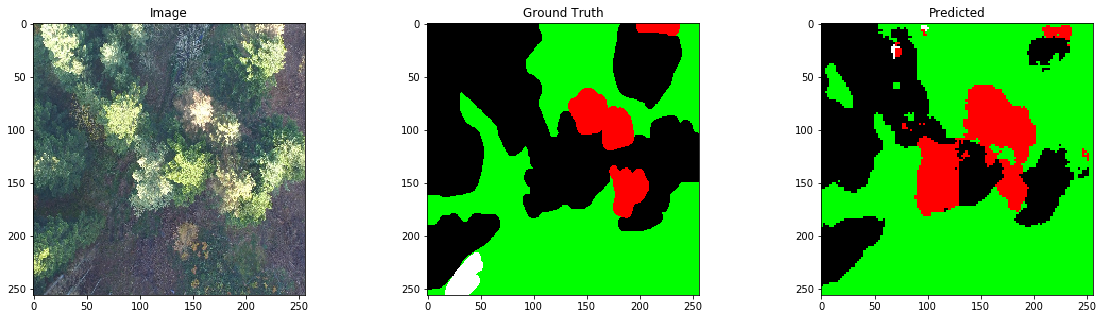

In [130]:
sample_image, sample_mask = set_sample_image('DJI_0219.JPG','DJI_0219.png')
pred = show_predictions()

Text(0.5, 1.0, 'dead')

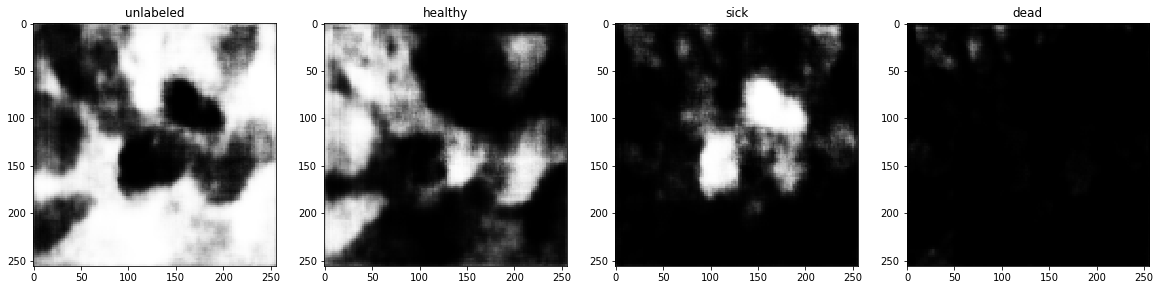

In [131]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))

plt.subplot(1, 4, 1)
plt.imshow(pred[0, :,:, 0], vmin=0, vmax=1, cmap='gray')
plt.title('unlabeled')

plt.subplot(1, 4, 2)
plt.imshow(pred[0, :,:, 1], vmin=0, vmax=1, cmap='gray')
plt.title('healthy')

plt.subplot(1, 4, 3)
plt.imshow(pred[0, :,:, 2], vmin=0, vmax=1, cmap='gray')
plt.title('sick')

plt.subplot(1,4,4)
plt.imshow(pred[0, :,:, 3], vmin=0, vmax=1, cmap='gray')
plt.title('dead')